In [1]:
# parameters
grid_size = 3 # size of averaging window for calculating AOD or other products
band = "55"
varPM = "PMc"
varAOD = "nAODm"
root_path = "/content/drive/MyDrive"

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd 
from sklearn import preprocessing
import os
from google.colab import drive
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# load data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/MyDrive"

 AQ1-Colab-Enesemble_learning   model.h5
 AQ-GAN			        PythonCodes
'Colab Notebooks'	       'Webinar registration form, Civil.gform'
 final_data		       'Webinar Registration Form, Geomatics.gform'


In [5]:
name = 'train' + ".csv"
path = os.path.join(root_path, 'final_data', name)
df = pd.read_csv(path)



#X = df[[varAOD, 'lat', 'long', 'Prob_bestm','d2m', 't2m', 'blh',
#       'sp', 'lai_hv', 'ws10', 'wd10', 'uvb', 
#       'RH', 'DOY']]
X = df[[varAOD, 'lat', 'long', 'Prob_bestm', 'Prob_medm', 'month', 'd2m', 't2m','blh',
        'sp', 'lai_hv', 'lai_lv', 'ws10', 'wd10', 'cdir', 'uvb', 
        'RH', 'DOY']]
#X = df[[varAOD, 'lat', 'long', 'Prob_medm', 'd2m', 't2m',
#       'lai_hv', 'ws10', 'uvb', 'RH', 'DOY']]
print(X.columns)
y = df[[varPM]]

scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
Xs.shape



Index(['nAODm', 'lat', 'long', 'Prob_bestm', 'Prob_medm', 'month', 'd2m',
       't2m', 'blh', 'sp', 'lai_hv', 'lai_lv', 'ws10', 'wd10', 'cdir', 'uvb',
       'RH', 'DOY'],
      dtype='object')


(15848, 18)

XGboost, final

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['r2','neg_mean_squared_error']
model = XGBRegressor(objective='reg:squarederror', n_estimators=2000, random_sate = 123)
# model.fit(X_train, y_train, verbose=True)
scores = cross_validate(model, Xs, y, scoring=scoring, cv=cv, n_jobs=-1)
print ("RMSE: ", round(np.mean(np.sqrt(abs(scores['test_neg_mean_squared_error']))),2))
print ("R2: ", round(np.mean(scores['test_r2']),2))

In [ ]:
import time
start = time.time()
df["y_pred"] = cross_val_predict(model, Xs, y, cv=cv)
print("Time of execution:",  (time.time() - start))

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
df["PMp"] = df.apply(NominalPM, axis = 1)


print ("RMSE: ", np.round(mean_squared_error(df["PM2.5"], df["PMp"], squared=False),2))
print ("MAE: ", np.round(mean_absolute_error(df["PM2.5"], df["PMp"]),2))
from scipy.stats import pearsonr
corr, _ = pearsonr(df["y_pred"], df["PMc"])
print('Pearsons R2 correlation: %.3f' % corr**2)

In [ ]:
# Save model
import pickle
output_path = root_path + "/PythonCodes"
pickle.dump(model, open(os.path.join(output_path, "PMXGB.pickle.dat"), "wb"))

In [ ]:
from sklearn.model_selection import cross_val_score
import time
start = time.time()
df["y_pred"] = cross_val_score(model, Xs, y, cv=cv)
print("Time of execution:",  (time.time() - start))

Feature Importance

In [8]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

xgb = XGBRegressor(n_estimators= 2000, random_sate = 123)
model = xgb.fit(Xs, y)

[06:24:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[0.1567142  0.06736777 0.10986797 0.01555055 0.0179394  0.01193059
 0.02680035 0.01456684 0.28334436 0.02207207 0.01584163 0.01367014
 0.01318216 0.0149865  0.01780669 0.02524792 0.14693753 0.02617338]


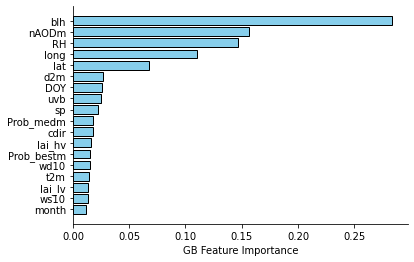

In [9]:
%matplotlib inline
print(xgb.feature_importances_)
# plot feature importance
sorted_idx = xgb.feature_importances_.argsort()
hfont = {'fontname':'Arial'}
fig, ax = plt.subplots()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx], edgecolor = "k", color = 'skyblue')
plt.xlabel("GB Feature Importance", **hfont)
plt.yticks(**hfont)
plt.xticks(**hfont)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


In [ ]:
# check the type of importance
xgb.importance_type

'gain'

In [ ]:
X.columns

In [ ]:
for importance_type in ('weight', 'gain', 'cover'):
    print('%s: ' % importance_type, model.get_booster().get_score(importance_type=importance_type))
    print('%s: ' % importance_type, model.get_booster().get_score(importance_type=importance_type).keys())
    # print('%s: ' % importance_type, sorted(model.get_booster().get_score(importance_type=importance_type))) 

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(xgb, Xs , y)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
Xf = pd.concat([X, y], axis=1)
Xf.head()

,nAODm,lat,long,Prob_bestm,Prob_medm,month,d2m,t2m,blh,sp,lai_hv,lai_lv,ws10,wd10,cdir,uvb,RH,DOY,PMc
0,1.008228,35.79587,51.48414,0.250000,0.500000,1,264.461232,273.190126,220.188379,1.830098,0.481037,80783.59502,0.477509,8.818764e+05,109668.9151,1.077084,0.820740,1,312.396030
1,1.123350,35.79587,51.48414,0.222222,0.333333,1,267.116013,275.019316,173.294144,1.830098,0.481037,79896.67097,-0.979731,8.750107e+05,107564.3345,0.996014,0.837088,6,319.189967
2,0.365492,35.79587,51.48414,0.472222,0.500000,1,260.902897,271.902280,358.420500,1.830634,0.481206,81160.79649,-0.363244,1.008016e+06,128177.4696,1.082716,0.778359,16,144.377785
3,0.254065,35.79587,51.48414,0.388889,0.500000,1,264.961503,277.057037,354.673214,1.831409,0.481433,80439.59862,-0.907281,1.016449e+06,130119.8619,2.435351,0.761573,18,180.348937
4,0.453122,35.79587,51.48414,0.611111,0.694444,1,265.292177,277.802793,200.828925,1.831811,0.481514,80649.05957,-1.094077,1.038862e+06,130804.6252,1.180017,0.754764,19,244.662111


[Text(0, 0.5, 'nAODm'),
 Text(0, 1.5, 'lat'),
 Text(0, 2.5, 'long'),
 Text(0, 3.5, 'Prob_bestm'),
 Text(0, 4.5, 'Prob_medm'),
 Text(0, 5.5, 'month'),
 Text(0, 6.5, 'd2m'),
 Text(0, 7.5, 't2m'),
 Text(0, 8.5, 'blh'),
 Text(0, 9.5, 'sp'),
 Text(0, 10.5, 'lai_hv'),
 Text(0, 11.5, 'lai_lv'),
 Text(0, 12.5, 'ws10'),
 Text(0, 13.5, 'wd10'),
 Text(0, 14.5, 'cdir'),
 Text(0, 15.5, 'uvb'),
 Text(0, 16.5, 'RH'),
 Text(0, 17.5, 'DOY'),
 Text(0, 18.5, 'PMc')]

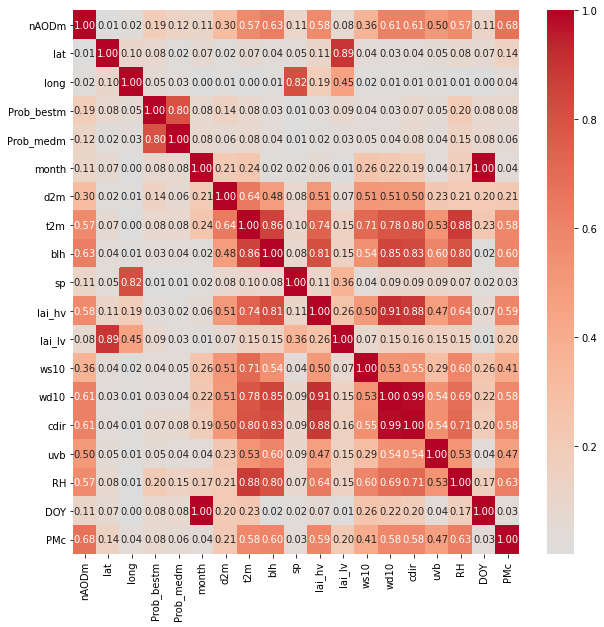

In [ ]:
hfont = {'fontname':'Arial'}
corrmat = Xf.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(abs(Xf[top_corr_features].corr()), annot=True, vmax=1.0, center=0, fmt='.2f', cmap ='coolwarm')
g.set_xticklabels(g.get_xticklabels(), **hfont)
g.set_yticklabels(g.get_xticklabels(), **hfont)

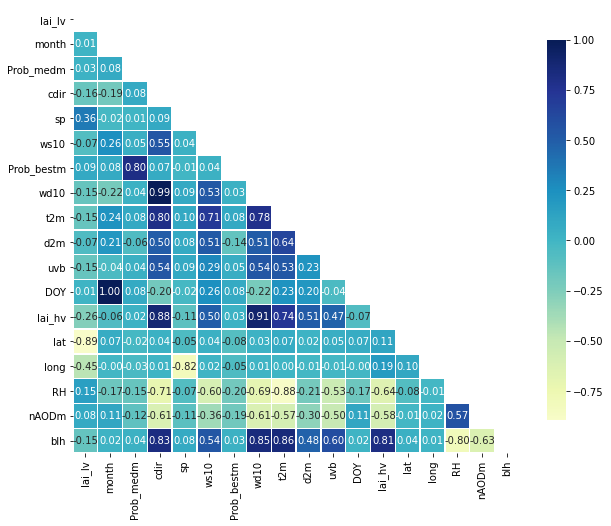

In [ ]:

import seaborn as sns
def correlation_heatmap(train):
    correlations = train.corr()
    mask = np.triu(np.ones_like(correlations, dtype=bool))

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, mask = mask, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(Xf[Xf.columns[sorted_idx]])

XGboost, No. of Trees

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['r2','neg_mean_squared_error']
n_estimators = [1000,1500,2000]
param_grid = dict(n_estimators=n_estimators)
model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, random_sate = 123)
# model.fit(X_train, y_train, verbose=True)
#scores = cross_validate(model, Xs, y, scoring=scoring, cv=cv, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, cv=cv, refit='neg_mean_squared_error')
grid_result = grid_search.fit(Xs, y)
print("parameters: ", grid_result.best_params_)
print ("MSE: ", round(np.min(np.sqrt(abs(grid_result.cv_results_['mean_test_neg_mean_squared_error']))),2))
print ("R2: ", round(np.max(grid_result.cv_results_['mean_test_r2']),2))

In [ ]:
# Dart
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['r2','neg_mean_squared_error']

model = XGBRegressor(booster = 'dart', objective ='reg:linear', n_estimators = 1000, seed = 234)
# model.fit(X_train, y_train, verbose=True)
scores = cross_validate(model, Xs, y, scoring=scoring, cv=cv, n_jobs=-1)
print ("RMSE: ", round(np.mean(np.sqrt(abs(scores['test_neg_mean_squared_error']))),2))
print ("R2: ", round(np.mean(scores['test_r2']),2))

RMSE:  30.82
R2:  0.77


In [ ]:
import time
start = time.time()
df["y_pred"] = cross_val_predict(model, Xs, y, cv=cv)
print("Time of execution:",  (time.time() - start))

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
df["PMp"] = df.apply(NominalPM, axis = 1)


print ("RMSE: ", np.round(mean_squared_error(df["PM2.5"], df["PMp"], squared=False),2))
print ("MAE: ", np.round(mean_absolute_error(df["PM2.5"], df["PMp"]),2))
from scipy.stats import pearsonr
corr, _ = pearsonr(df["y_pred"], df["PMc"])
print('Pearsons R2 correlation: %.3f' % corr**2)

[07:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re